<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Brain_Tumor_Detection_using_YOLO_v10_and_SAM_coronal_t1wce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Brain tumor object detection datasets](https://www.kaggle.com/datasets/davidbroberts/brain-tumor-object-detection-datasets)

## Refference

- [Brain Tumor Detection using YOLO v10](https://www.kaggle.com/code/metinmekiabullrahman/brain-tumor-detection-using-yolo-v10)
- [Brain_Tumor_Detection (SAM)](https://www.kaggle.com/code/giovanniimbesi/brain-tumor-detection)

## 0. Setting for Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics
!pip install wandb
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.8/823.8 kB 9.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## [Early Stpopping](https://note.com/kiyo_ai_note/n/nac73b50f3b78)

In [3]:
'''
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
      #Saves model when validation loss decrease.
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
'''

'\nimport numpy as np\nimport torch\n\nclass EarlyStopping:\n    """Early stops the training if validation loss doesn\'t improve after a given patience."""\n    def __init__(self, patience=7, verbose=False, delta=0, path=\'checkpoint.pt\', trace_func=print):\n        """\n        Args:\n            patience (int): How long to wait after last time validation loss improved.\n                            Default: 7\n            verbose (bool): If True, prints a message for each validation loss improvement.\n                            Default: False\n            delta (float): Minimum change in the monitored quantity to qualify as an improvement.\n                            Default: 0\n            path (str): Path for the checkpoint to be saved to.\n                            Default: \'checkpoint.pt\'\n            trace_func (function): trace print function.\n                            Default: print\n        """\n        self.patience = patience\n        self.verbose = verbose\n      

In [4]:
import shutil
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/axial_t1wce_2_class.zip', './')
shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/coronal_t1wce_2_class.zip', './')
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/sagittal_t1wce_2_class.zip', './')

In [5]:
files = os.listdir('./coronal_t1wce_2_class/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

84 (4)


In [6]:
with open(os.path.join('./coronal_t1wce_2_class/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

(512, 512, 3)


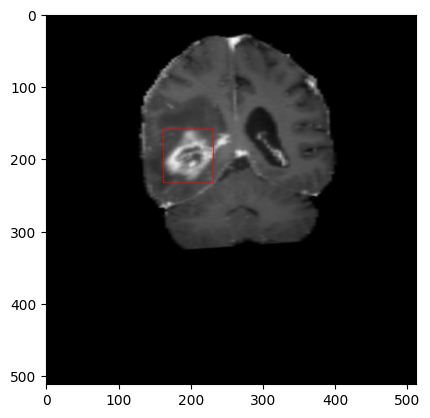

In [7]:
img = cv2.imread(os.path.join('./coronal_t1wce_2_class/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [8]:
train_images = os.listdir('./coronal_t1wce_2_class/images/train')
test_images = os.listdir('./coronal_t1wce_2_class/images/test')
train_labels = os.listdir('./coronal_t1wce_2_class/labels/train')
test_labels = os.listdir('./coronal_t1wce_2_class/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

319 78
318 78


In [9]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('./coronal_t1wce_2_class/images/train', image))

In [10]:
train_images = os.listdir('./coronal_t1wce_2_class/images/train')
test_images = os.listdir('./coronal_t1wce_2_class/images/test')
train_labels = os.listdir('./coronal_t1wce_2_class/labels/train')
test_labels = os.listdir('./coronal_t1wce_2_class/images/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

318 78
318 78


In [11]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('./coronal_t1wce_2_class/images/val'):
    shutil.rmtree('./coronal_t1wce_2_class/images/val')
if os.path.exists('./coronal_t1wce_2_class/labels/val'):
    shutil.rmtree('./coronal_t1wce_2_class/labels/val')

os.mkdir('./coronal_t1wce_2_class/images/val')
os.mkdir('./coronal_t1wce_2_class/labels/val')

for image in val_images:
    shutil.move(os.path.join('./coronal_t1wce_2_class/images/train', image), './coronal_t1wce_2_class/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('./coronal_t1wce_2_class/labels/train', label), './coronal_t1wce_2_class/labels/val')

In [12]:
text ="""
path: ../coronal_t1wce_2_class
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""

with open('./fixed_path.yaml', 'w') as file:
    file.write(text)

In [13]:
model = YOLO('yolov10s.pt')

100%|██████████| 15.9M/15.9M [00:00<00:00, 94.7MB/s]


In [14]:
#early_stopping = EarlyStopping()
results = model.train(data='./fixed_path.yaml', batch=-1, epochs=50, device=0)

Ultralytics YOLOv8.2.63 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10s.pt, data=./fixed_path.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

100%|██████████| 755k/755k [00:00<00:00, 23.5MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 51.0MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.25G reserved, 0.10G allocated, 14.39G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     8067900       24.77         0.682         42.87           nan        (1, 3, 640, 640)                    list
     8067900       49.55         1.267         37.74           nan        (2, 3, 640, 640)                    list
     8067900        99.1         2.462         39.89           nan        (4, 3, 640, 640)                    list
     8067900       198.2         4.706         57.56           nan        (8, 3, 640, 640)                    list
     8067900       396.4         9.091         92.86           nan       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 15 for CUDA:0 8.92G/14.75G (60%) ✅


train: Scanning /content/coronal_t1wce_2_class/labels/train... 255 images, 0 backgrounds, 0 corrupt: 100%|██████████| 255/255 [00:00<00:00, 2190.76it/s]

train: New cache created: /content/coronal_t1wce_2_class/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/coronal_t1wce_2_class/labels/val... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<00:00, 601.82it/s]

val: New cache created: /content/coronal_t1wce_2_class/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.00046875), 111 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.26G      3.405      35.39      3.038         28        640: 100%|██████████| 17/17 [00:11<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all         63         68      0.237      0.117      0.136      0.083



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.24G      2.502      11.79      2.267         30        640: 100%|██████████| 17/17 [00:11<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         63         68      0.025      0.158       0.02     0.0138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.24G      2.592       5.63       2.33         14        640: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         63         68      0.185      0.447      0.143      0.093



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.24G      2.648      4.539      2.358         18        640: 100%|██████████| 17/17 [00:07<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         63         68      0.344      0.538       0.34      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.24G      2.668        3.7       2.35         28        640: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         63         68      0.251      0.424      0.221      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.24G      2.638      3.448      2.362         35        640: 100%|██████████| 17/17 [00:08<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         63         68    0.00886      0.282    0.00558    0.00284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.24G      2.829      3.552      2.422         21        640: 100%|██████████| 17/17 [00:08<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         63         68    0.00886      0.282    0.00558    0.00284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.24G      2.622      3.153      2.319         21        640: 100%|██████████| 17/17 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         63         68      0.418      0.494      0.342      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.24G      2.635      3.037      2.332         23        640: 100%|██████████| 17/17 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         63         68   0.000161     0.0758   9.39e-05   2.48e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.24G      2.608      3.052      2.365         25        640: 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         63         68      0.467      0.546      0.428      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.24G      2.601      3.038       2.31         25        640: 100%|██████████| 17/17 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         63         68      0.533      0.766      0.549      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.24G       2.63      2.748      2.327         28        640: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         63         68      0.388      0.295      0.279       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.24G      2.539      2.742      2.242         28        640: 100%|██████████| 17/17 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         63         68      0.254      0.223      0.142     0.0605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.24G      2.555      2.723      2.269         27        640: 100%|██████████| 17/17 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         63         68      0.509      0.626       0.51      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.24G      2.406      2.763      2.275         15        640: 100%|██████████| 17/17 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         63         68      0.264      0.221      0.198      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.24G      2.316      2.668      2.214         21        640: 100%|██████████| 17/17 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

                   all         63         68      0.458      0.816      0.588      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.24G      2.231      2.461      2.215         26        640: 100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         63         68      0.464      0.776      0.575      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.24G      2.429      2.548      2.204         22        640: 100%|██████████| 17/17 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         63         68      0.477      0.674      0.464      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.24G       2.33      2.472      2.174         20        640: 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         63         68       0.47      0.785      0.521      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.24G        2.3      2.482      2.165         19        640: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         63         68      0.482      0.774      0.496      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.24G      2.302      2.451      2.119         26        640: 100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         63         68      0.419      0.728        0.5      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.24G      2.209      2.369      2.133         20        640: 100%|██████████| 17/17 [00:09<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         63         68      0.477      0.806      0.517      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.24G      2.178      2.435      2.146         23        640: 100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

                   all         63         68      0.474      0.762      0.596      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.24G      2.083      2.343      2.101         19        640: 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         63         68      0.481       0.69       0.55      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.24G      2.053      2.431      2.077         27        640: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         63         68      0.439      0.792      0.572      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.24G       2.06       2.25      2.072         24        640: 100%|██████████| 17/17 [00:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         63         68      0.481      0.866       0.65      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.24G      2.086      2.339      2.122         19        640: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         63         68      0.528      0.778      0.626      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.24G      2.143      2.296      2.137         17        640: 100%|██████████| 17/17 [00:06<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         63         68      0.478      0.822      0.637      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.23G      2.003       2.24      2.076         30        640: 100%|██████████| 17/17 [00:07<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         63         68      0.513      0.776      0.641      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.24G      1.953      2.245      2.075         30        640: 100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         63         68       0.66      0.675      0.673      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.24G      1.924      2.201      2.048         25        640: 100%|██████████| 17/17 [00:07<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]

                   all         63         68      0.476      0.881      0.651      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.24G      2.011       2.15      2.035         26        640: 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

                   all         63         68      0.528      0.717      0.639       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.24G      1.859      2.118      1.991         34        640: 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

                   all         63         68      0.471       0.74      0.632      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.24G      1.944      2.129      2.023         22        640: 100%|██████████| 17/17 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         63         68      0.441      0.911      0.618      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.24G      1.875      2.123      1.982         22        640: 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         63         68      0.481       0.85       0.69      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.24G      1.825      2.007      1.942         21        640: 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all         63         68      0.533      0.748      0.706      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.24G      1.824      2.141      1.973         25        640: 100%|██████████| 17/17 [00:09<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         63         68      0.568      0.683       0.69      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.24G      1.797      2.046      1.938         35        640: 100%|██████████| 17/17 [00:06<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         63         68      0.625      0.662      0.731      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.24G      1.766      2.024      1.919         16        640: 100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         63         68      0.574      0.727      0.695      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.24G      1.812      1.984      1.994         16        640: 100%|██████████| 17/17 [00:07<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

                   all         63         68      0.606      0.699      0.698      0.562


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.24G      1.653      1.918      1.933         16        640: 100%|██████████| 17/17 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         63         68      0.571      0.816      0.679      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.24G      1.589      1.846      1.928         15        640: 100%|██████████| 17/17 [00:07<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         63         68      0.604      0.812      0.708       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.24G      1.517      1.786      1.875         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         63         68      0.596      0.788      0.711      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.24G      1.508      1.729      1.882         16        640: 100%|██████████| 17/17 [00:08<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         63         68      0.576      0.807      0.749      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.24G       1.53       1.78      1.844         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

                   all         63         68      0.639      0.777      0.756      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.24G       1.52      1.714      1.891         17        640: 100%|██████████| 17/17 [00:08<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         63         68      0.638       0.77      0.786      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.24G      1.459      1.617      1.837         17        640: 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         63         68      0.648       0.69      0.772      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.24G      1.418      1.641      1.829         15        640: 100%|██████████| 17/17 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         63         68        0.6      0.813      0.769      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.24G      1.425      1.606      1.819         15        640: 100%|██████████| 17/17 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

                   all         63         68      0.553      0.809      0.751      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.24G      1.391      1.627      1.835         17        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         63         68       0.66      0.704      0.772      0.625



50 epochs completed in 0.145 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 16.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 16.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.63 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10s summary (fused): 293 layers, 8,036,508 parameters, 0 gradients, 24.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


                   all         63         68      0.639      0.772      0.784      0.636
              negative         33         35      0.614      0.829      0.829       0.67
              positive         30         33      0.663      0.715      0.738      0.602
Speed: 0.3ms preprocess, 7.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


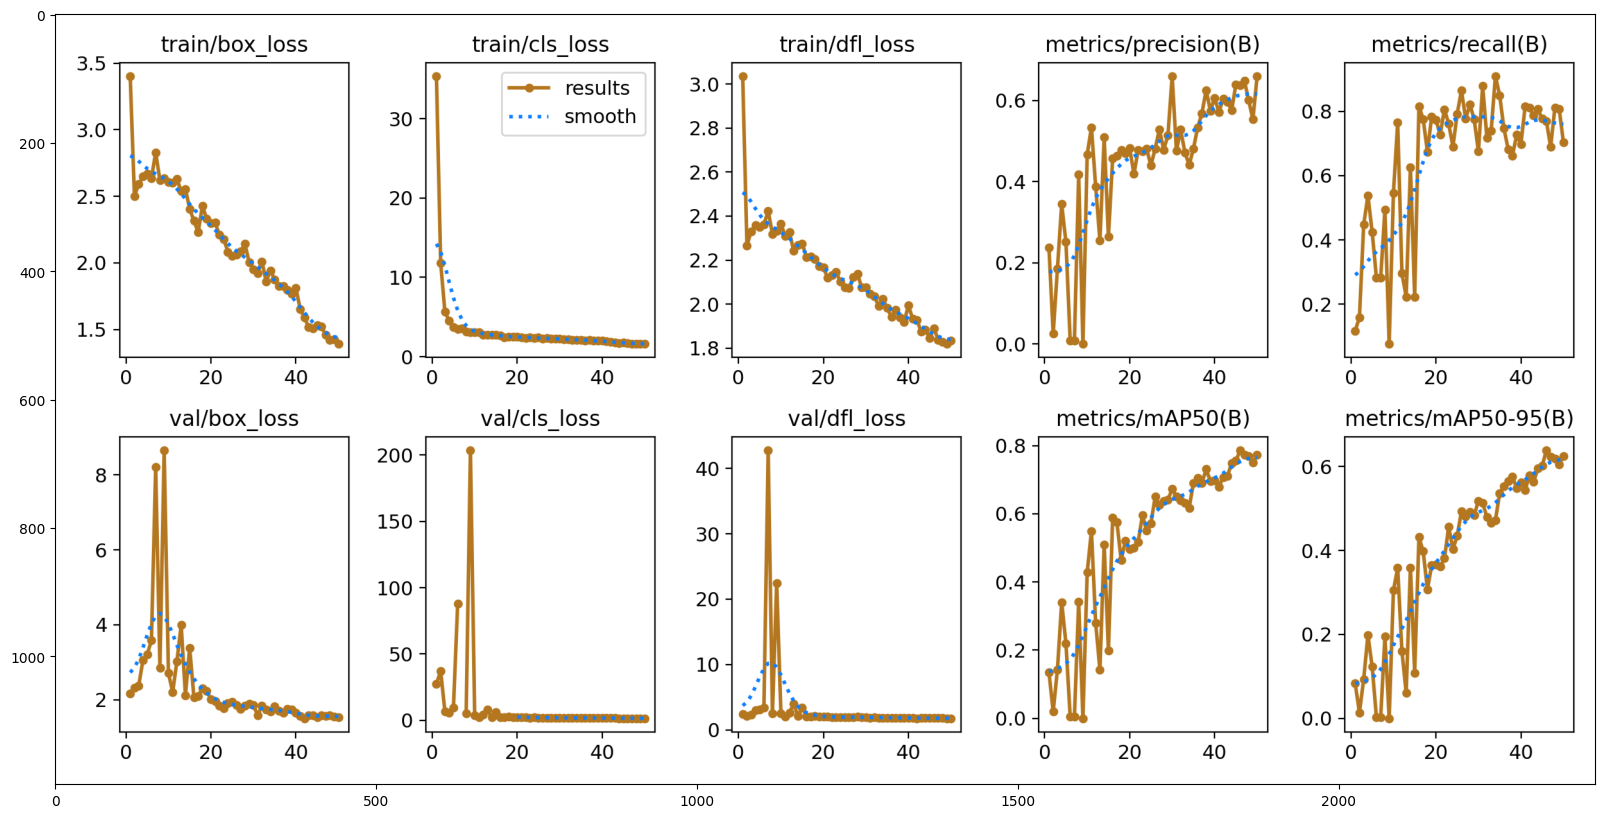

In [15]:
training_save_dir = './' + str(results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

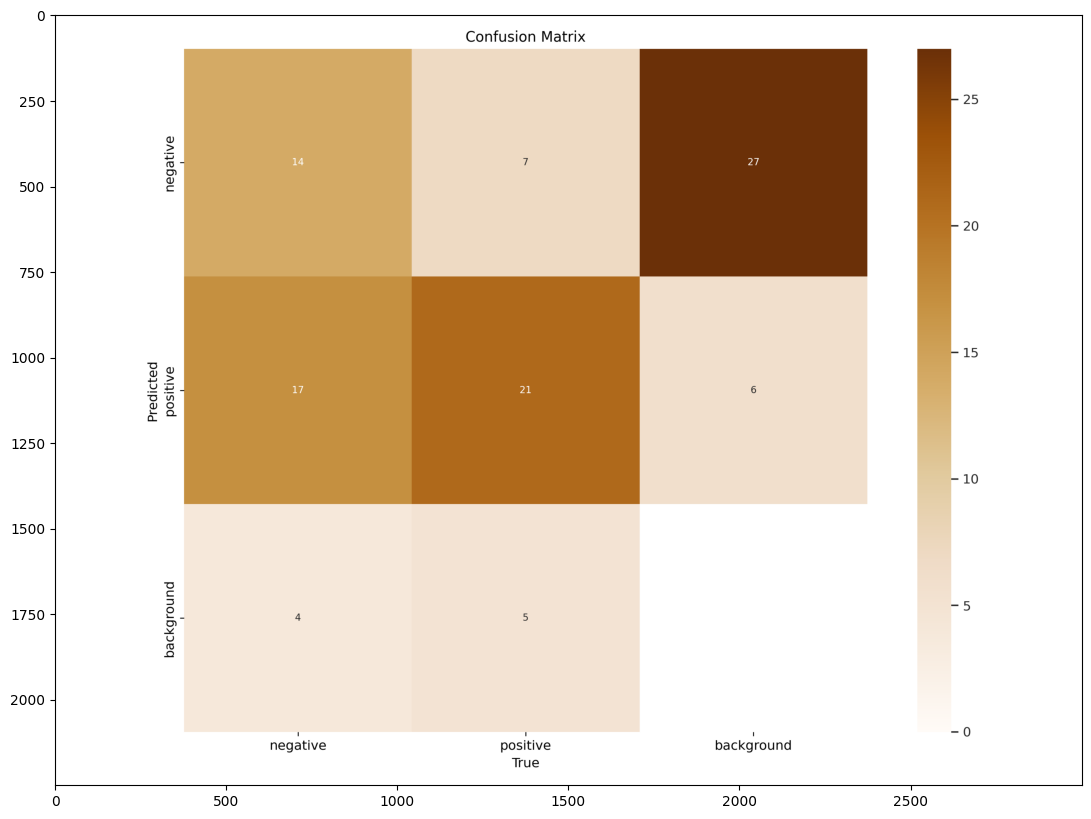

In [16]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

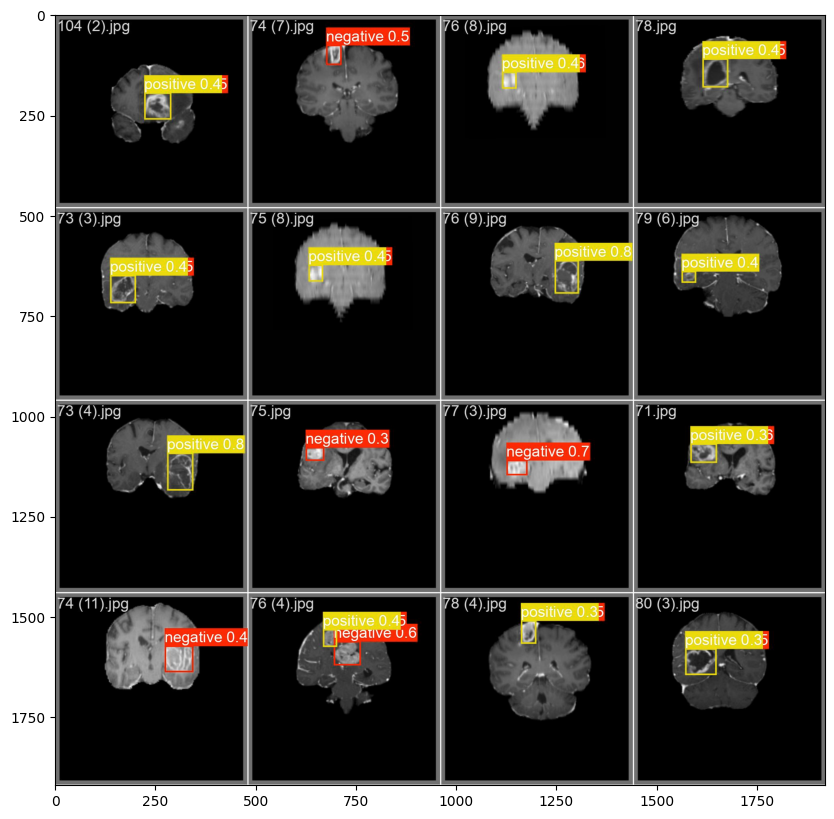

In [17]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

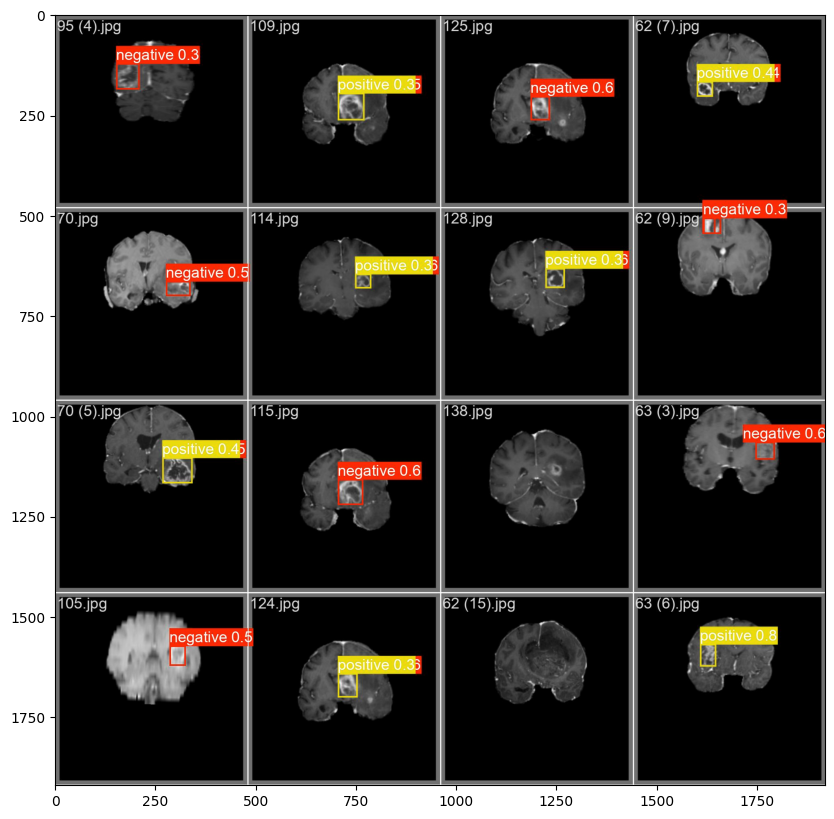

In [18]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

In [19]:
trained_model = YOLO(training_save_dir + '/weights/best.pt')
predictions = trained_model.predict(
    source="./coronal_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/78 /content/coronal_t1wce_2_class/images/test/13.jpg: 640x640 (no detections), 17.3ms
image 2/78 /content/coronal_t1wce_2_class/images/test/15.jpg: 640x640 1 positive, 20.7ms
image 3/78 /content/coronal_t1wce_2_class/images/test/17.jpg: 640x640 1 positive, 27.7ms
image 4/78 /content/coronal_t1wce_2_class/images/test/19.jpg: 640x640 1 negative, 17.7ms
image 5/78 /content/coronal_t1wce_2_class/images/test/20.jpg: 640x640 1 negative, 26.2ms
image 6/78 /content/coronal_t1wce_2_class/images/test/23.jpg: 640x640 1 negative, 22.8ms
image 7/78 /content/coronal_t1wce_2_class/images/test/33.jpg: 640x640 1 negative, 19.2ms
image 8/78 /content/coronal_t1wce_2_class/images/test/34.jpg: 640x640 1 negative, 20.5ms
image 9/78 /content/coronal_t1wce_2_class/images/test/35.jpg: 640x640 1 negative, 24.4ms
image 10/78 /content/coronal_t1wce_2_class/images/test/36.jpg: 640x640 1 negative, 17.3ms
image 11/78 /content/coronal_t1wce_2_class/images/test/38.jpg: 640x640 1 negative, 15.8ms
image 12/78 /

In [20]:
predictions_save_dir = './' + predictions[0].save_dir + '/labels'

In [21]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

['0', '0.351854', '0.238918', '0.115467', '0.104352', '0.458088\n']
['0', '0.352113', '0.238850', '0.117371', '0.102113']


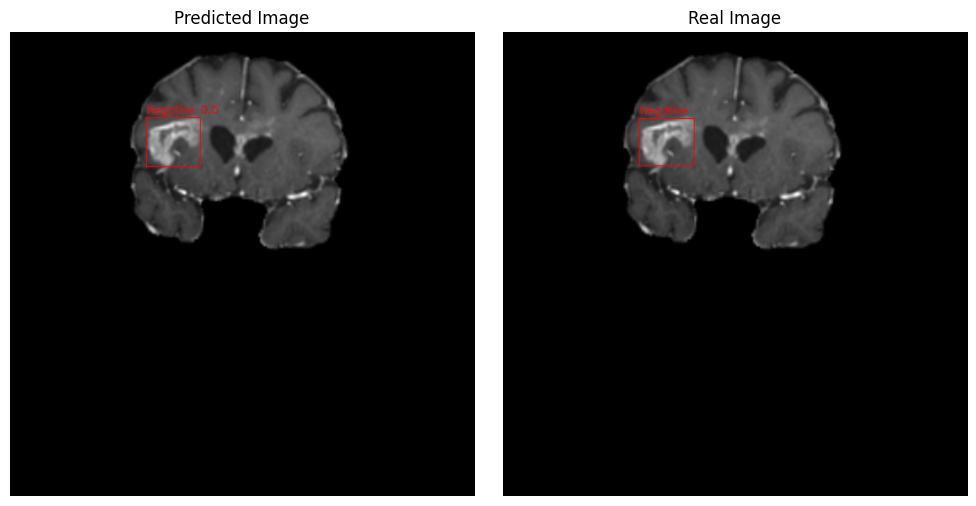

In [22]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('./coronal_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('./coronal_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('./coronal_t1wce_2_class/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [23]:
text = """
path: ../coronal_t1wce_2_class
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [24]:
metrics = trained_model.val(data="./test.yaml")

Ultralytics YOLOv8.2.63 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/coronal_t1wce_2_class/labels/test... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<00:00, 1891.54it/s]

val: New cache created: /content/coronal_t1wce_2_class/labels/test.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


                   all         78         83       0.45      0.829      0.528      0.392
              negative         32         34       0.38      0.882      0.534      0.404
              positive         46         49      0.521      0.776      0.522      0.379
Speed: 0.5ms preprocess, 29.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val


In [25]:
test_save_dir = './' + str(metrics.save_dir)

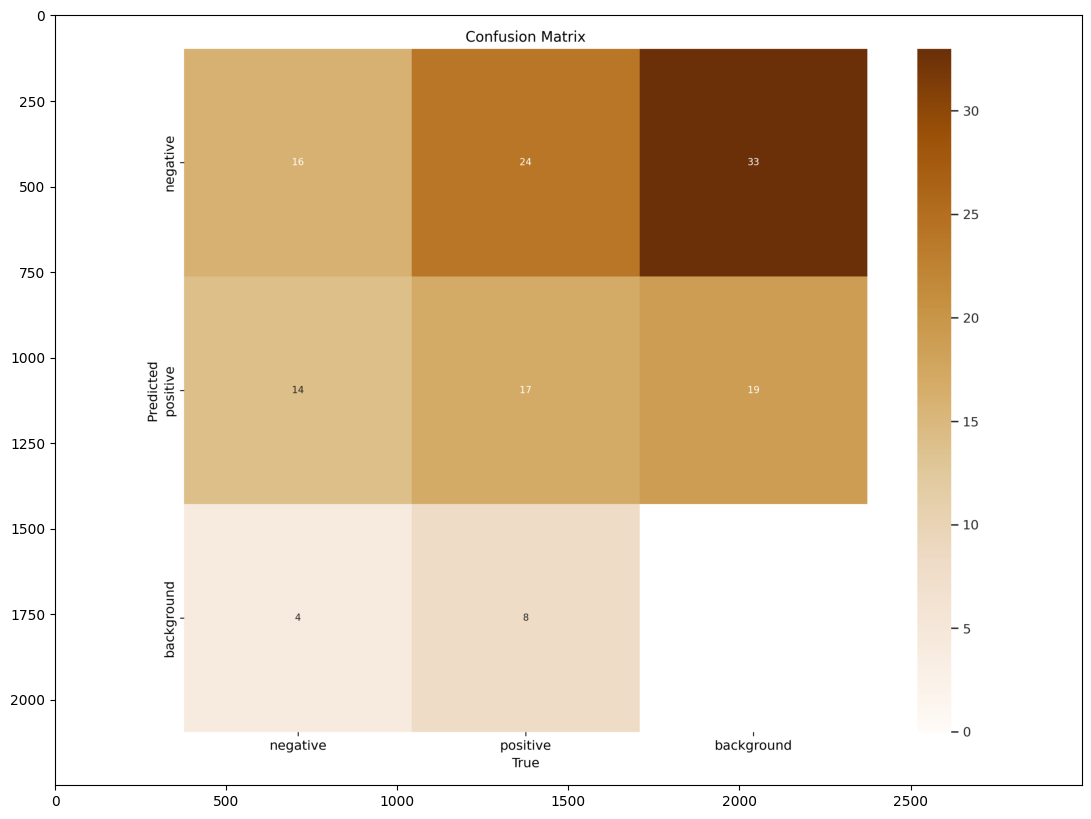

In [26]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

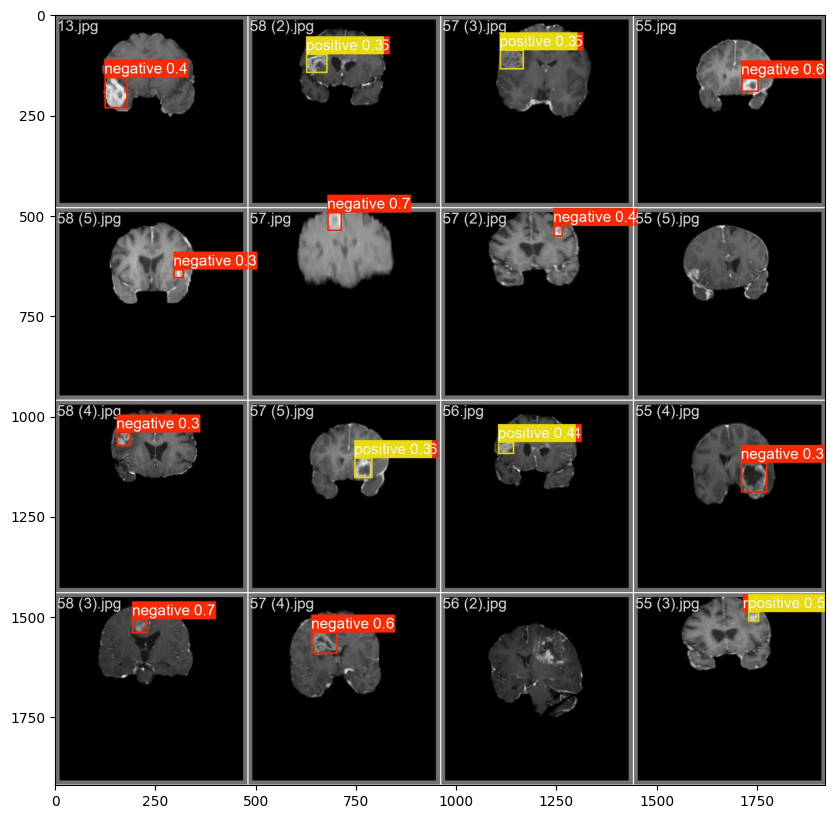

In [27]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

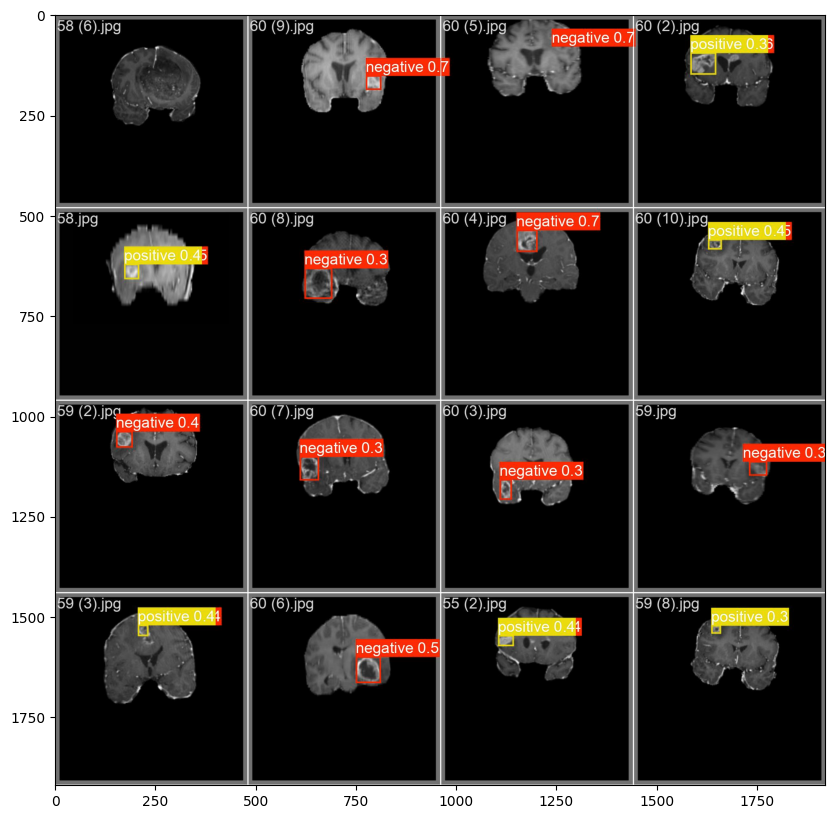

In [28]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

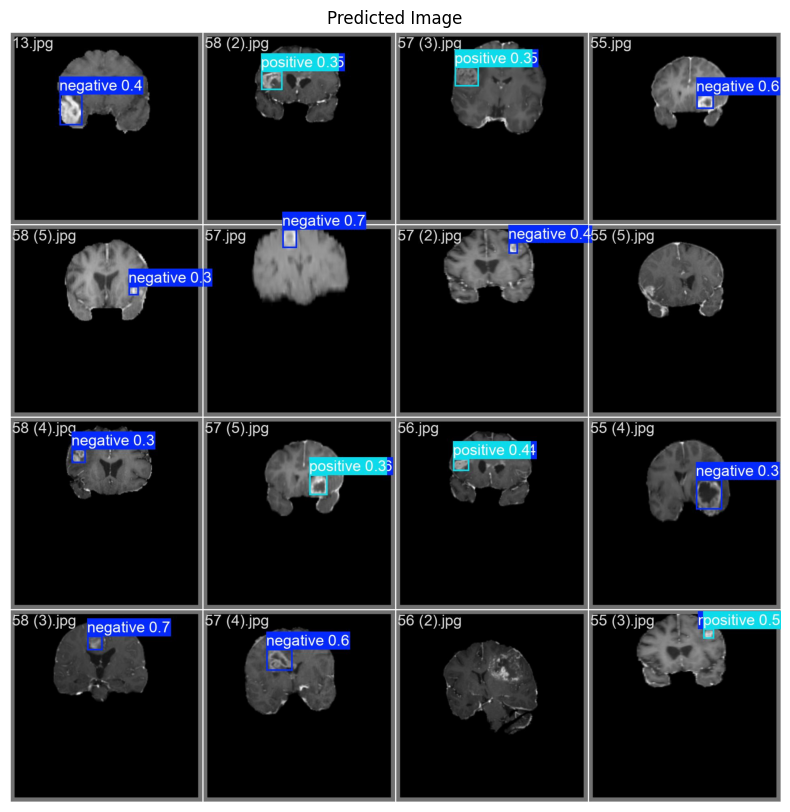

In [29]:
image_path = os.path.join(test_save_dir, 'val_batch0_pred.jpg')

# Create a figure with a specified size
plt.figure(figsize=(20, 10))

# Read the image using OpenCV
img = cv2.imread(image_path)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display

# Add a title to the plot (optional)
plt.title('Predicted Image')

# Show the plot
plt.axis('off')  # Hide axis ticks and labels
plt.show()

## [SAM(Segment Anything Model)](https://segment-anything.com/)

In [30]:
real_path = os.path.join('./coronal_t1wce_2_class/images/test', f'{random_file}.jpg')

In [31]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [32]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ayol4x42
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ayol4x42
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=590301dcaba78f8969e2f2e23120590b538a720d5a2f2d8d3b61b36c1cf1ec31
  Stored in directory: /tmp/pip-ephem-wheel-cache-lmdzo5ol/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [33]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: line 1: {sys.executable}: command not found
--2024-07-23 01:35:28--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  84.5MB/s    in 31s     

2024-07-23 01:35:59 (79.5 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [34]:
image = cv2.cvtColor(cv2.imread(real_path), cv2.COLOR_BGR2RGB)
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = 0
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(img_pred)

In [35]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [36]:
model=YOLO('./runs/detect/train/weights/best.pt')
results = model.predict(source=real_path, conf=0.25)
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]


image 1/1 /content/coronal_t1wce_2_class/images/test/58 (2).jpg: 640x640 1 negative, 1 positive, 25.0ms
Speed: 56.9ms preprocess, 25.0ms inference, 36.6ms postprocess per image at shape (1, 3, 640, 640)


In [37]:
print(bbox)

[150.5894012451172, 95.6118392944336, 209.70864868164062, 149.04010009765625]


In [38]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/prompt_encoder.py:199: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  y_embed = grid.cumsum(dim=0) - 0.5
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/prompt_encoder.py:200: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  x_embed = grid.cumsum(dim=1) - 0.5


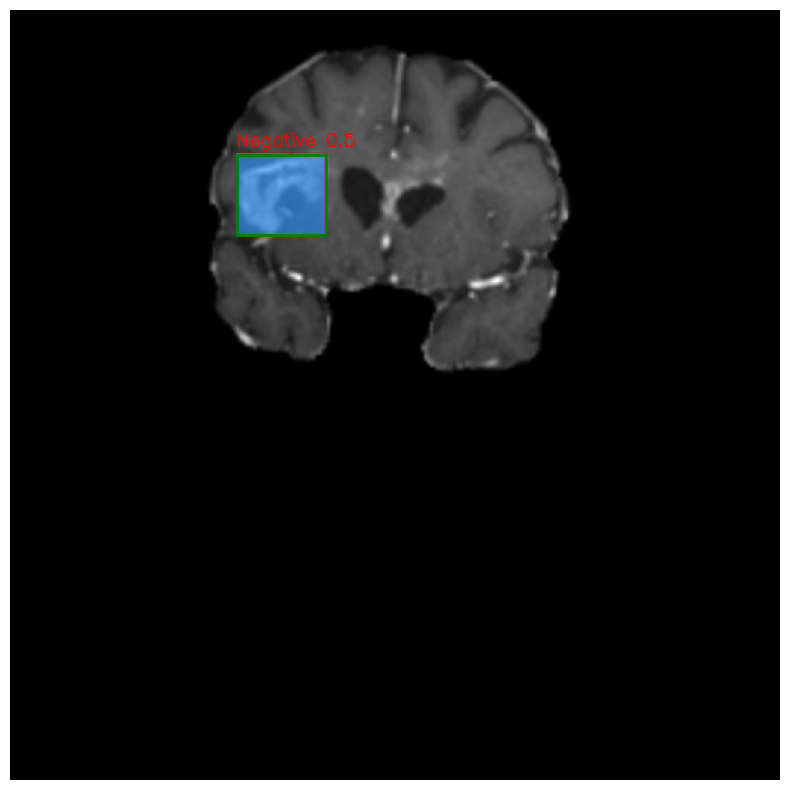

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(img_pred, cmap='gray')
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()